In [1]:
%matplotlib notebook

import matplotlib as mpl
import DataSetQuery
import datetime
import pandas as pd
import MalardHelpers
import geopandas as gp
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import Polygon, Point
from osgeo import gdal
import os
import numpy as np
from scipy.interpolate import griddata
import pandas as  pd
import geopandas as gp
from osgeo import gdal
import os
import json
import math
from pandas.io.json import json_normalize


In [2]:
environmentName = 'DEVv2'
query = DataSetQuery.DataSetQuery('http://localhost:9000',environmentName)

# 400000 500000 0 100000 mtngla testdataset HMA RGIv60 SDCv10 DebugRun
parentDsName = 'mtngla'
dataset = 'tdxtest1'
runName='DebugRun'
region='himalayas'

#Setup the bounding box
minX=400000
maxX=500000
minY=0
maxY=100000
bbx = query.getDataSetBoundingBox(parentDsName, dataset)
bbx = json.loads(bbx)
minT = datetime.datetime.utcfromtimestamp(bbx['minTime'])
maxT = datetime.datetime.utcfromtimestamp(bbx['maxTime'])

#The overall data cube for the two datasets
print(query.getDataSetBoundingBox(parentDsName,dataset, region))

{"gridCellMinX":400000,"gridCellMaxX":500000,"gridCellMinY":0,"gridCellMaxY":100000,"minTime":1279306567,"maxTime":1536722938,"totalPoints":692,"numberOfShards":1}


In [4]:
fp = query.executeQuery( parentDsName,dataset,region,minX,maxX,minY,maxY,minT,maxT,[],[])
df = MalardHelpers.getDataFrameFromNetCDF(fp)

In [5]:
df.head()

,index,lon,lat,elev,heading,demDiff,demDiffMad,demDiffMad2,phaseAmb,meanDiffSpread,...,phaseConfidence,coh,x,y,time,swathFileId,dataset,debris,refElevation,refDifference
0,0,89.935996,36.428723,5362.771484,185.698181,27.057306,8.705181,7.377079,0,672.65033,...,NaN,0.954,434358.275728,59256.220830,1406958933,9010,,0,5364.696971,-1.925487
1,592764,89.935402,36.428050,5363.312500,185.688385,32.896729,2.735479,2.918242,0,678.98822,...,NaN,0.963,434309.838269,59177.614497,1343327224,938,,0,5338.889182,24.423318
2,592765,89.935329,36.428056,5363.059082,185.688385,32.643623,2.735479,2.918242,0,678.98822,...,NaN,0.989,434303.432098,59177.967755,1343327224,938,,0,5336.895189,26.163893
3,592766,89.935236,36.428063,5362.800781,185.688385,32.385071,2.735479,2.918242,0,678.98822,...,NaN,0.988,434295.145982,59178.424680,1343327224,938,,0,5334.405128,28.395654
4,592767,89.935265,36.428061,5362.573730,185.688385,32.158375,2.735479,2.918242,0,678.98822,...,NaN,0.974,434297.709691,59178.283308,1343327224,938,,0,5335.164651,27.409079


In [207]:
df.columns

Index(['index', 'lon', 'lat', 'elev', 'heading', 'demDiff', 'demDiffMad',
       'demDiffMad2', 'phaseAmb', 'meanDiffSpread', 'wf_number', 'sampleNb',
       'power', 'powerdB', 'phase', 'phaseS', 'phaseSSegment',
       'phaseConfidence', 'coh', 'x', 'y', 'time', 'swathFileId', 'dataset',
       'debris', 'refElevation', 'refDifference', 'year', 'month', 'day',
       'date', 'dateobject', 'yearmonth'],
      dtype='object')

In [121]:
size=100000
year = []
month = []
yearmonth = []
day = []
dateobject = []
xdiff = []
ydiff = []
# glacial year
gla_year = []
for i, row in df.iterrows():
    date = datetime.datetime.utcfromtimestamp(df.time[i])
    year.append(date.year)
    month.append(date.month)
    day.append(date.day)
    dateobject.append(date)
    yearmonth.append('%s-%s' % (date.year, date.month))
    # x and y distance to center point of gridcell
    xdiff.append((df.x[i] % size) - (size/2))
    ydiff.append((df.y[i] % size) - (size/2))
    if date.month < 10:
        gla_year.append(date.year)
    else:
        gla_year.append(date.year+1)
    
df['year'] = year
df['gla_year'] = gla_year
df['month'] = month
df['day'] = day
df['dateobject'] = dateobject
df['yearmonth'] = yearmonth
df['offsetX'] = xdiff
df['offsetY'] = ydiff
df[df.columns[10:25]]

,wf_number,sampleNb,power,powerdB,phase,phaseS,phaseSSegment,phaseConfidence,coh,x,y,time,swathFileId,dataset,debris
0,1302,149,12952.735352,-155.952194,1.484199,NaN,NaN,NaN,0.954,434358.275728,59256.220830,1406958933,9010,,0
1,1206,150,24905.468750,-154.466003,1.671181,NaN,NaN,NaN,0.963,434309.838269,59177.614497,1343327224,938,,0
2,1206,151,33204.566406,-150.141571,1.668179,NaN,NaN,NaN,0.989,434303.432098,59177.967755,1343327224,938,,0
3,1206,152,33908.320312,-150.902908,1.664296,NaN,NaN,NaN,0.988,434295.145982,59178.424680,1343327224,938,,0
4,1206,153,28889.119141,-153.040329,1.665497,NaN,NaN,NaN,0.974,434297.709691,59178.283308,1343327224,938,,0
5,1206,154,22273.878906,-154.820724,1.671395,NaN,NaN,NaN,0.955,434310.297477,59177.589174,1343327224,938,,0
6,1206,155,15762.069336,-158.828049,1.680413,NaN,NaN,NaN,0.887,434329.544282,59176.527837,1343327224,938,,0
7,1318,150,23866.736328,-157.725632,0.150396,NaN,NaN,NaN,0.862,431285.879331,54509.017003,1406958933,9010,,0
8,1318,151,29937.703125,-153.978317,0.168156,NaN,NaN,NaN,0.946,431323.760674,54506.926032,1406958933,9010,,0
9,1318,152,27558.621094,-155.313751,0.159091,NaN,NaN,NaN,0.949,431304.424378,54507.993357,1406958933,9010,,0


<IPython.core.display.Javascript object>


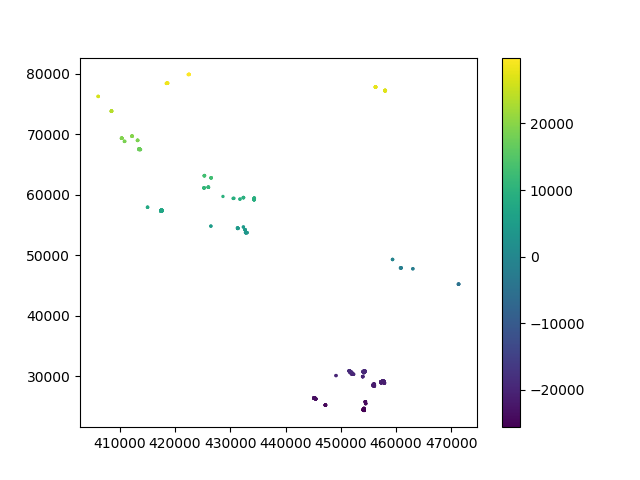

In [17]:
%matplotlib notebook
plt.scatter(x=df.x, y=df.y, c=df.offsetY, marker='.', s=8)
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


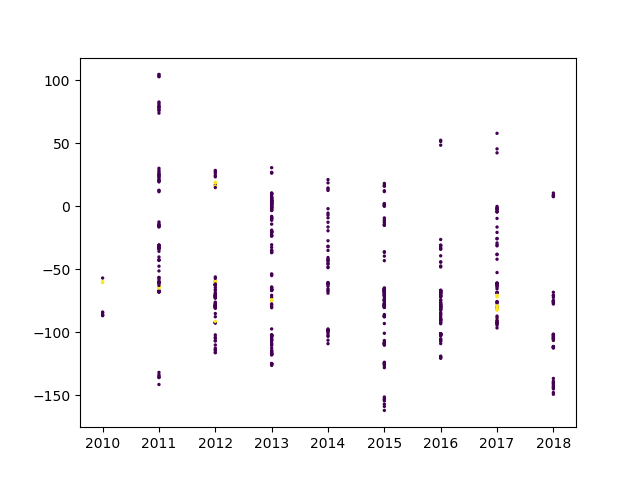

In [95]:
%matplotlib notebook
plt.scatter(x=df.gla_year, y=df.refDifference, c=df.debris, marker='.', s=8, label=['debris', 'no-debris'])
#plt.legend()
plt.show()

<IPython.core.display.Javascript object>


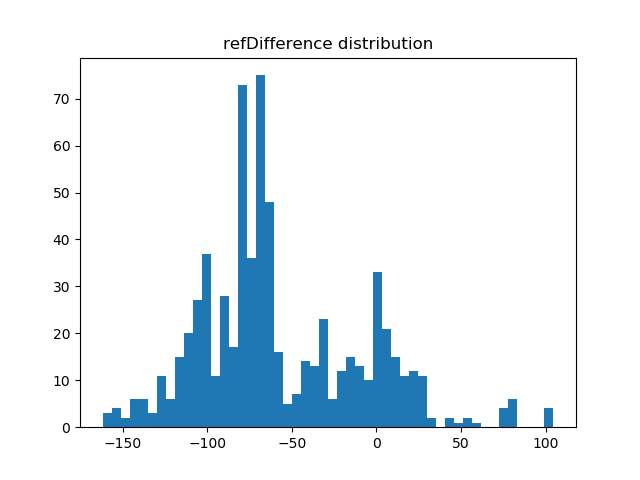

In [32]:
%matplotlib notebook
plt.hist(df.refDifference, bins=50)
plt.title('refDifference distribution')
plt.show()

<IPython.core.display.Javascript object>


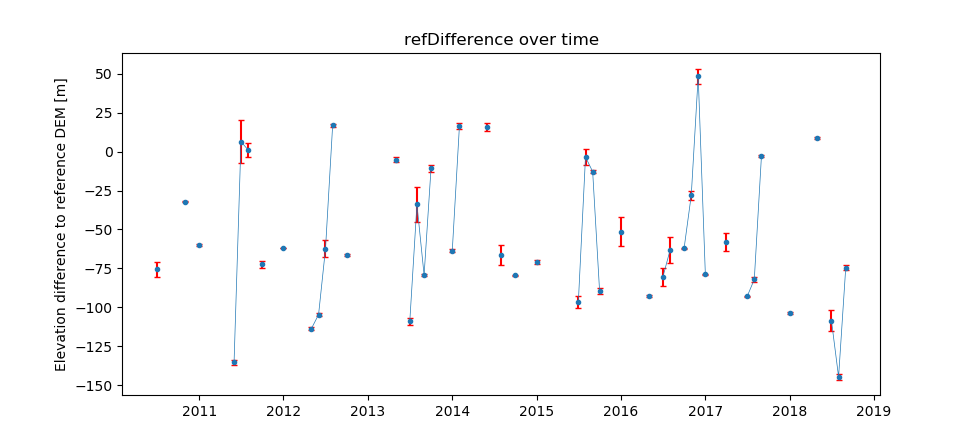

In [124]:
%matplotlib notebook
from dateutil.relativedelta import *
#averages = df.groupby(['year','month']).refDifference.mean()
averages = []
dates = []
errors = []

use_date = datetime.datetime(2010,1,1,0,0)
while use_date <= datetime.datetime(2019,1,1,0,0):
    df_filt = df[(df.month == use_date.month) & (df.year == use_date.year)]
    averages.append(df_filt.refDifference.mean())
    dates.append(use_date)
    errors.append(df_filt.refDifference.sem())
    #df_filt = df.query('month=%s && year=%s'  % (use_date.month, use_date.year))
    use_date = use_date+relativedelta(months=+1)

plt.errorbar(x=dates, y=averages, yerr=errors, marker='.', ecolor='red', elinewidth=1.5, capsize=2, linewidth=0.5)
plt.title('refDifference over time')
plt.ylabel('Elevation difference to reference DEM [m]')
plt.show()

In [97]:
df_filtered = df[(df.gla_year > 2010) & (df.gla_year < 2019)]

coefficient of determination: 0.39949146079116415
intercept: 9627.798100404803
slope: [-4.81693340e+00 -2.14418397e-04 -1.74948234e-03]


<IPython.core.display.Javascript object>


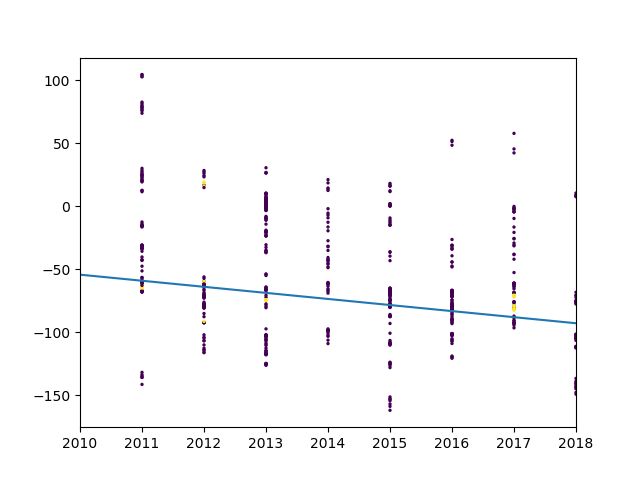

In [100]:
# linear regression with scikit
# step 1 import packages
%matplotlib notebook
import numpy as np
from sklearn.linear_model import LinearRegression

# step 2 - provide data
vals = np.asarray([df_filtered.year.values, df_filtered.offsetY, df_filtered.offsetX])
x = np.transpose(vals)
#x = (df.year.values).reshape((-1, 1))
y = df_filtered.refDifference
# step 3 - create model and fir it
model = LinearRegression().fit(x, y)

# step 4 - get results
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_) # b0
print('slope:', model.coef_) # b1

# predict cell centre
predict = model.predict([[2010,0,0],[2011,0,0],[2012,0,0],[2013,0,0],[2014,0,0],[2015,0,0],[2016,0,0],[2017,0,0],[2018,0,0]])

years=[i for i in range(2010, 2019)]
plt.plot(years, predict)
#plt.scatter(x=df.time, y=df.refDifference, c=df.debris, marker='.', s=8)
plt.scatter(x=df_filtered.gla_year, y=df_filtered.refDifference, c=df_filtered.debris, marker='.', s=8)
plt.xlim(2010, 2018)
plt.show()

In [102]:
# linear regression with statsmodel
# step 1 import packages
import statsmodels.api as sm

# step 2 - provide data
vals = np.asarray([df_filtered.gla_year.values, df_filtered.offsetY, df_filtered.offsetX])
x = np.transpose(vals)
#x = (df.year.values- 2010).reshape((-1, 1))
y = df_filtered.refDifference
x = sm.add_constant(x)

# step 3 - create model and fit it (least squares)
#model = sm.RLM(y, x)
model = sm.OLS(y, x)
results = model.fit()

# step 4 - get results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          refDifference   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     146.9
Date:                Tue, 23 Jul 2019   Prob (F-statistic):           2.79e-73
Time:                        14:39:28   Log-Likelihood:                -3428.3
No. Observations:                 679   AIC:                             6865.
Df Residuals:                     675   BIC:                             6883.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9181.5754   1395.761      6.578      0.000    6441.019    1.19e+04
x1            -4.5951      0.693     -6.632      0.000      -5.956      -3.235
x2            -0.0002      0.000     -2.028      0.043      -0.000   -7.24e-06
x3            -0.0017      0.000    -14.097      0.000      -0.002      -0.002
==============================================================================
Omnibus:                       78.377   Durbin-Watson:                   0.327
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              199.974
Skew:                           0.606   Prob(JB):                     3.77e-44
Kurtosis:                       5.366   Cond. No.                     2.24e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.24e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
plt.plot(years, predict)
#plt.scatter(x=df.time, y=df.refDifference, c=df.debris, marker='.', s=8)
plt.scatter(x=df.year, y=df.refDifference, c=df.debris, marker='.', s=8)
plt.xlim(2010, 2018)
plt.show()

In [56]:
stats = query.getRunStatistics(parentDsName, runName)
stats = json.loads(stats)
dfStats = json_normalize(stats)
dfStats.head()

,gridCell.minX,gridCell.minY,gridCell.size,statistics.afterDebrisMask,statistics.afterGlacierMask,statistics.debrisMaskArea,statistics.glacierMaskArea,statistics.joined_data,statistics.pointsOnDebris,statistics.result_avgX,...,statistics.result_refDifference_2015,statistics.result_refDifference_2016,statistics.result_refDifference_2017,statistics.result_refDifference_2018,statistics.result_srtm,statistics.result_tandemx,statistics.result_total,statistics.srtm_filtered,statistics.srtm_not_in,statistics.tandemX_filtered
0,400000,0,100000,657.0,692,1.80089,164.495799,2212970,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2160090,99376,2113594
1,400000,0,100000,657.0,692,1.80089,164.495799,2212970,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2160090,99376,2113594
2,400000,0,100000,657.0,692,1.80089,164.495799,2212970,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2160090,99376,2113594
3,400000,0,100000,657.0,692,1.80089,164.495799,2212970,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2160090,99376,2113594
4,400000,0,100000,657.0,692,1.80089,164.495799,2212970,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2160090,99376,2113594


In [59]:
# get means
means=[]
years=[i for i in range(2010, 2019)]
for i in years:
    means.append(dfStats['statistics.result_refDifference_%s'% i ][42])

<IPython.core.display.Javascript object>


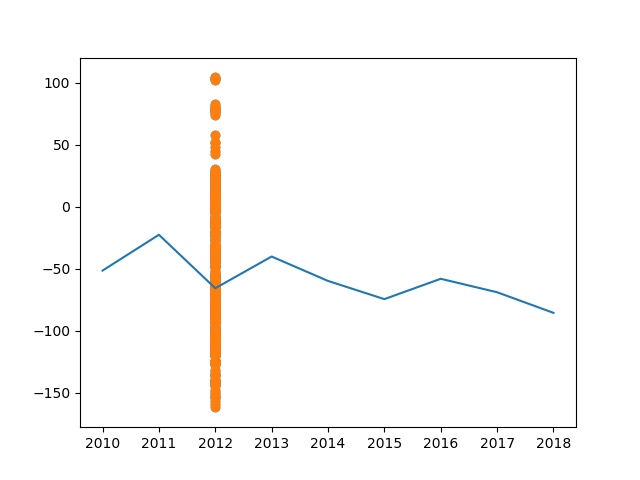

In [60]:
plt.plot(years, means)